# Vote autochtone

## Liste des communautés autochtones

Le site [Services aux Autochtones Canada](https://www.sac-isc.gc.ca/fra/1634312499368/1634312554965) du gouvernement fédéral fournit la liste de toutes les nations communautés autochtones du Québec.

BeautifulSoup est utilisé pour récupérer les données inscrites dans les tableaux du site.

In [1]:
import requests
from bs4 import BeautifulSoup

communities_url = 'https://www.sac-isc.gc.ca/fra/1634312499368/1634312554965'
page = requests.get(communities_url)
soup = BeautifulSoup(page.text, 'html.parser')

### Extraction des données sur les communautés

In [2]:
import pandas as pd
import numpy as np

NATION_COL = 'Nation'
COMMUNITY_COL = 'Communauté'

communities = pd.DataFrame(columns=[NATION_COL, COMMUNITY_COL]).set_index(COMMUNITY_COL)

# Les balises 'h4' correspondent aux noms des familles de nations, et sont suivies d'un tableau des nations et communautés
nations_html = soup.find_all('h4')
for nation_html in nations_html:
    nation_name = nation_html.getText()
    # Récupère le tableau suivant le nom 
    table = nation_html.find_all_next('table')[0]
    df = pd.read_html(str(table))[0]

    # Élimine les lignes contenant le total ou des informations additionnelles, et ne garde que la colonne 'Toponyme'
    df = df[~df['Toponyme'].str.startswith('Total', na=False)]
    
    # Élimine les lignes contenant des informations additionnelles
    df = df[df['Toponyme'] != df['Résidents']]

    # # Élimine les communautés sans résidents
    # df = df[df['Résidents'].astype(str) != '0']

    # Ne garde que la colonne toponyme
    df = df.loc[:, 'Toponyme']
    # Remplit le DataFrame avec les communautés trouvées
    # PS: Les données fédérales et les données d'Élections Québec ne correspondant pas tout à fait, un sale travail de glue ci-dessous est nécessaire...
    for value in df.values:
        if value == 'Betsiamites':
            value = 'Pessamit'
        if value == 'Romaine':
            value = 'La Romaine'
        elif value == 'Rapid Lake':
            value = 'Lac-Rapide'
        elif value == 'Nemiscau':
            value = 'Nemaska'
        elif value == 'Matimekosh, Lac-John':
            communities = pd.concat([communities, pd.DataFrame([[nation_name, 'Lac-John']], columns=[NATION_COL, COMMUNITY_COL])])
            communities = pd.concat([communities, pd.DataFrame([[nation_name, 'Matimekosh']], columns=[NATION_COL, COMMUNITY_COL])])
            continue
        elif value == 'Uashat, Maliotenam':
            communities = pd.concat([communities, pd.DataFrame([[nation_name, 'Uashat']], columns=[NATION_COL, COMMUNITY_COL])])
            communities = pd.concat([communities, pd.DataFrame([[nation_name, 'Maliotenam']], columns=[NATION_COL, COMMUNITY_COL])])
            continue
        communities = pd.concat([communities, pd.DataFrame([[nation_name, value]], columns=[NATION_COL, COMMUNITY_COL])])


## Résultats par bureau de vote

Le site d'[Élections Québec](https://www.dgeq.org/) fournit l'ensemble des données des élections provinciales 2022 par bureau de vote, sous format CSV.

In [3]:
from urllib.request import urlretrieve
import os
import zipfile

results_url = "https://www.dgeq.org/doc/gen2022-10-03/resultats-bureau-vote.zip"
results_zip = "resultats.zip"
results_path = "resultats"

# Créer le dossier de stockage des résultats s'il n'existe pas (s'il existe, assume que les données ont déjà été téléchargées et dézippées)
if not os.path.isdir(results_path):
    os.mkdir(results_path)

    # Télécharger puis dézipper les résultats s'ils ne l'ont pas déjà été
    if not os.path.exists(results_zip):
        urlretrieve(results_url, results_zip)
        with zipfile.ZipFile(results_zip, 'r') as zip_ref:
            zip_ref.extractall(results_path)

### Récupération de la liste des partis politiques

In [4]:
candidates_url = "https://www.dgeq.org/doc/gen2022-10-03/candidatures.json"

headers = {'Accept': 'application/json'}
r = requests.get(candidates_url, headers=headers)
candidates = r.json()

parties = {c['abreviation_parti']: c['nom_parti'] for c in candidates if c['abreviation_parti']}
# Ajoute un parti fictif 'Indépendant'
parties['Ind'] = 'Indépendant'

# Configure les couleurs des partis politiques principaux
POLITICAL_COLORS = {
    'C.A.Q.-E.F.L.': '#00b4f1',
    'Q.S.': '#ff5505',
    'P.Q.': '#003eaa',
    'P.L.Q./Q.L.P.': '#ed1b2e',
    'P.C.Q-E.E.D.': '#163b7a',
}

# Configure les couleurs et position géographiques approximatives des nations autochtones 
INDIGENOUS_CONFIG = pd.DataFrame([
    ['Cris', 52.229556, -78.502344, '#6895ba'],
    ['Algonquins',  47.111489, -77.833080, '#66316e'],
    ['Inuits',  57.982131, -72.497684, '#e1e2e4'],
    ['Naskapis',    55.195711, -66.860871, '#d6a84a'],
    ['Innus',   50.189381, -61.828352, '#868d93'],
    ['Micmacs', 48.673580, -65.472705, '#a53e32'],
    ['Malécites',   47.835817, -68.980292, '#52745a'],
    ['Atikamekw',   48.152973, -74.278475, '#6c5930'],
    ['Hurons-Wendat',   46.868054, -71.368484, '#7db45f'],
    ['Abénakis',    46.237348, -72.369682, '#464f9c'],
    ['Mohawks', 45.274449, -73.898823, '#405c72'],
], columns=['Nation', 'Lat', 'Lon', 'Color'],).set_index('Nation')

### Extraction des données sur les votes par bureau de vote

In [5]:
import csv
import sys

# Nom des principales colonnes manipulées
CIRCONSCRIPTION_COL = 'Circonscription'
NOM_MUNICIPALITES_COL = 'Nom des Municipalités'
MUNICIPALITE_COL = 'Nom Municipalité'
TYPE_MUNICIPALITE_COL = 'Type Municipalité'
ELECTEUR_INSCRIT_COL = 'É.I.'
BULLETIN_VALIDE_COL = 'B.V.'
BULLETIN_REJETE_COL = 'B.R.'
PARTICIPATION_COL = '% Participation'


# Supprime le nom du candidat pour ne garder que le nom de parti,
# afin de pouvoir colliger les résultats par partis entre circonscriptions
# Les candidats indépendants sont considérés comme appartenant à un parti Ind
def rename_candidate_columns(col_name: str):
    c, _, p = col_name.rpartition(' ')
    if p in parties.keys():
      return p
    if p == 'Ind':
       return 'Ind'
    return col_name


# Supprime le nom du candidat pour ne garder que le nom de parti,
# afin de pouvoir colliger les résultats par partis entre circonscriptions
def split_municipality_column(name: str):
    if not name.startswith('BV'):
       return pd.Series(str(name).split(', '))
    return pd.Series([name, None])

In [6]:

# Parcours l'ensemble des fichiers CSV d'Élections Québec et remplit un DatFrame avec les données
dataframe = pd.DataFrame()
for dirpath, _, files in os.walk(results_path):
    for name in files:
      # Charge les résultats dans un DataFrame
      df = pd.read_csv(os.path.join(dirpath, name), sep=';', encoding='latin-1')
      # Renomme les colonnes des candidats pour les uniformiser avec les noms des partis
      df = df.rename(columns=rename_candidate_columns)
      # Conserve les données par circonscription
      dataframe = pd.concat([dataframe, df], ignore_index=True)

# Divise la colonne des Municipalités en nom/type juridique
dataframe[[MUNICIPALITE_COL, TYPE_MUNICIPALITE_COL]] = dataframe[NOM_MUNICIPALITES_COL].apply(split_municipality_column)
# Supprime les colonnes inutiles
dataframe.drop(labels=['Code', 'Date scrutin', 'Étendue', 'Secteur', 'Regroupement', 'Nom des Municipalités', 'S.V.'], axis='columns', inplace=True)

# Ajouter la colonne Nation
dataframe = dataframe.join(communities.set_index(COMMUNITY_COL), on=MUNICIPALITE_COL)

# Mettre des 0 à la place des valeurs vides, pour tous les partis
for party in parties.keys():
    dataframe[party] = dataframe[party].fillna(0)

# Ne garder que les colonnes utiles
columns = [CIRCONSCRIPTION_COL, MUNICIPALITE_COL, NATION_COL, ELECTEUR_INSCRIT_COL, BULLETIN_VALIDE_COL]
columns += [p for p in parties.keys()]
dataframe = dataframe.loc[:, columns]

### Aggréger les données par communauté

In [7]:
# Fonction de calcul:
# - remplace chaque nombre absolu de votes par le pourcentage de votes équivalent
# - ajoute le pourcentage d'abstention par rapport au nombres d'électeurs inscrits dans une colonne '% Participation'
def compute_percentages(df: pd.DataFrame) -> pd.DataFrame:
    for party in parties.keys():
        df[party] = df[party] / df[BULLETIN_VALIDE_COL] * 100
    df[PARTICIPATION_COL] = 100 - (df[ELECTEUR_INSCRIT_COL] - df[BULLETIN_VALIDE_COL]) / df[ELECTEUR_INSCRIT_COL] * 100
    return df

In [8]:
# Regroupe tous les bureaux de votes non-autochtones en une seule communauté fictive 'Non autochtone' par circonscription
df_non_indidenous = dataframe[(dataframe[MUNICIPALITE_COL] != 'Total de la circonscription') & (dataframe[NATION_COL].isna())].copy()
df_non_indidenous = df_non_indidenous.groupby(CIRCONSCRIPTION_COL).sum(numeric_only=True).reset_index()
df_non_indidenous[MUNICIPALITE_COL] = 'Non autochtones'
df_non_indidenous[NATION_COL] = 'Non autochtones'

# Regroupe toutes les lignes "Total de la circonscription", par circonscription
df_totals = dataframe[dataframe[MUNICIPALITE_COL] == 'Total de la circonscription'].copy()
df_totals[NATION_COL] = df_totals[NATION_COL].fillna('Total')

# Regroupe tous les bureaux de vote autochtones par municipalité/territoire, par circonscription
df_indigenous = dataframe[~dataframe[NATION_COL].isna()].groupby([CIRCONSCRIPTION_COL, NATION_COL, MUNICIPALITE_COL]).sum(numeric_only=True).reset_index()

# Liste l'ensemble des circonscriptions comprenant des bureaux de votes en territoire autochtone
indigenous_districts = df_indigenous[CIRCONSCRIPTION_COL].unique()

# Combine l'ensemble des tableaux en un seul
# contenant, par circonscription, nation et communauté, l'ensemble des votes
combined_df = pd.concat([df_indigenous, df_non_indidenous, df_totals]).groupby([CIRCONSCRIPTION_COL, NATION_COL, MUNICIPALITE_COL], dropna=False).sum().reset_index()

### Aggréger les données par nation au niveau des circonscriptions

In [9]:
df_by_nation_by_discrict = combined_df.groupby([CIRCONSCRIPTION_COL, NATION_COL]).sum(numeric_only=True).sort_values([CIRCONSCRIPTION_COL, NATION_COL]).reset_index()
df_by_nation_by_discrict = compute_percentages(df_by_nation_by_discrict)

### Aggréger les données par nation au niveau national

In [10]:
df_by_nation = combined_df.groupby([NATION_COL]).sum(numeric_only=True).sort_values([NATION_COL]).reset_index()

df_indigenous_global = df_by_nation[df_by_nation[NATION_COL].isin(INDIGENOUS_CONFIG.index)].sum(numeric_only=True)
df_indigenous_global = compute_percentages(df_indigenous_global)

df_by_nation = compute_percentages(df_by_nation)

## Résultats

### Participation

Le premier graphique affiche le taux de participation par Nation (les non-autochtones étant considérés comme une nation fictive):

<Axes: title={'center': 'Partitipation'}, xlabel='% Participation', ylabel='Communauté'>

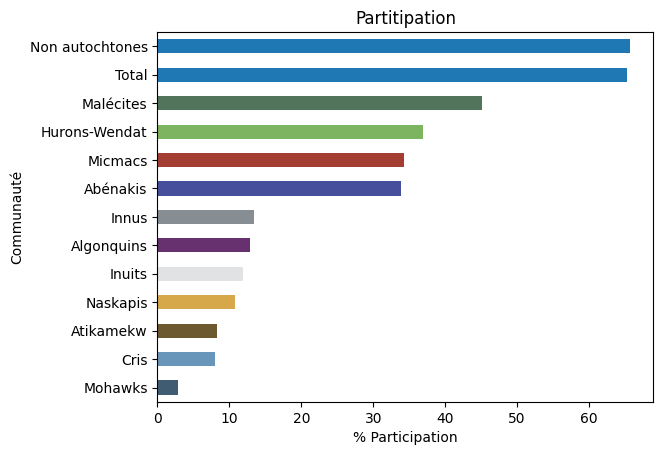

In [11]:
participation_df = df_by_nation[[NATION_COL, PARTICIPATION_COL]].set_index(NATION_COL).join(INDIGENOUS_CONFIG, on=NATION_COL)
participation_df = participation_df.sort_values(PARTICIPATION_COL)
participation_df['Color'].fillna('C0', inplace=True)
colors = list(participation_df['Color'])

participation_df[[PARTICIPATION_COL]].squeeze().plot.barh(
    title='Partitipation', ylabel='Communauté', xlabel='% Participation', legend=False, color=colors)

### Résultat des votes

#### Vote par nation

Le graphique suivant présente les résultats des votes des nations (les non-autochtones étant considérés comme une nation fictive). Seuls les partis principaux sont comptés, les résultats des partis mineurs étant négligeables.

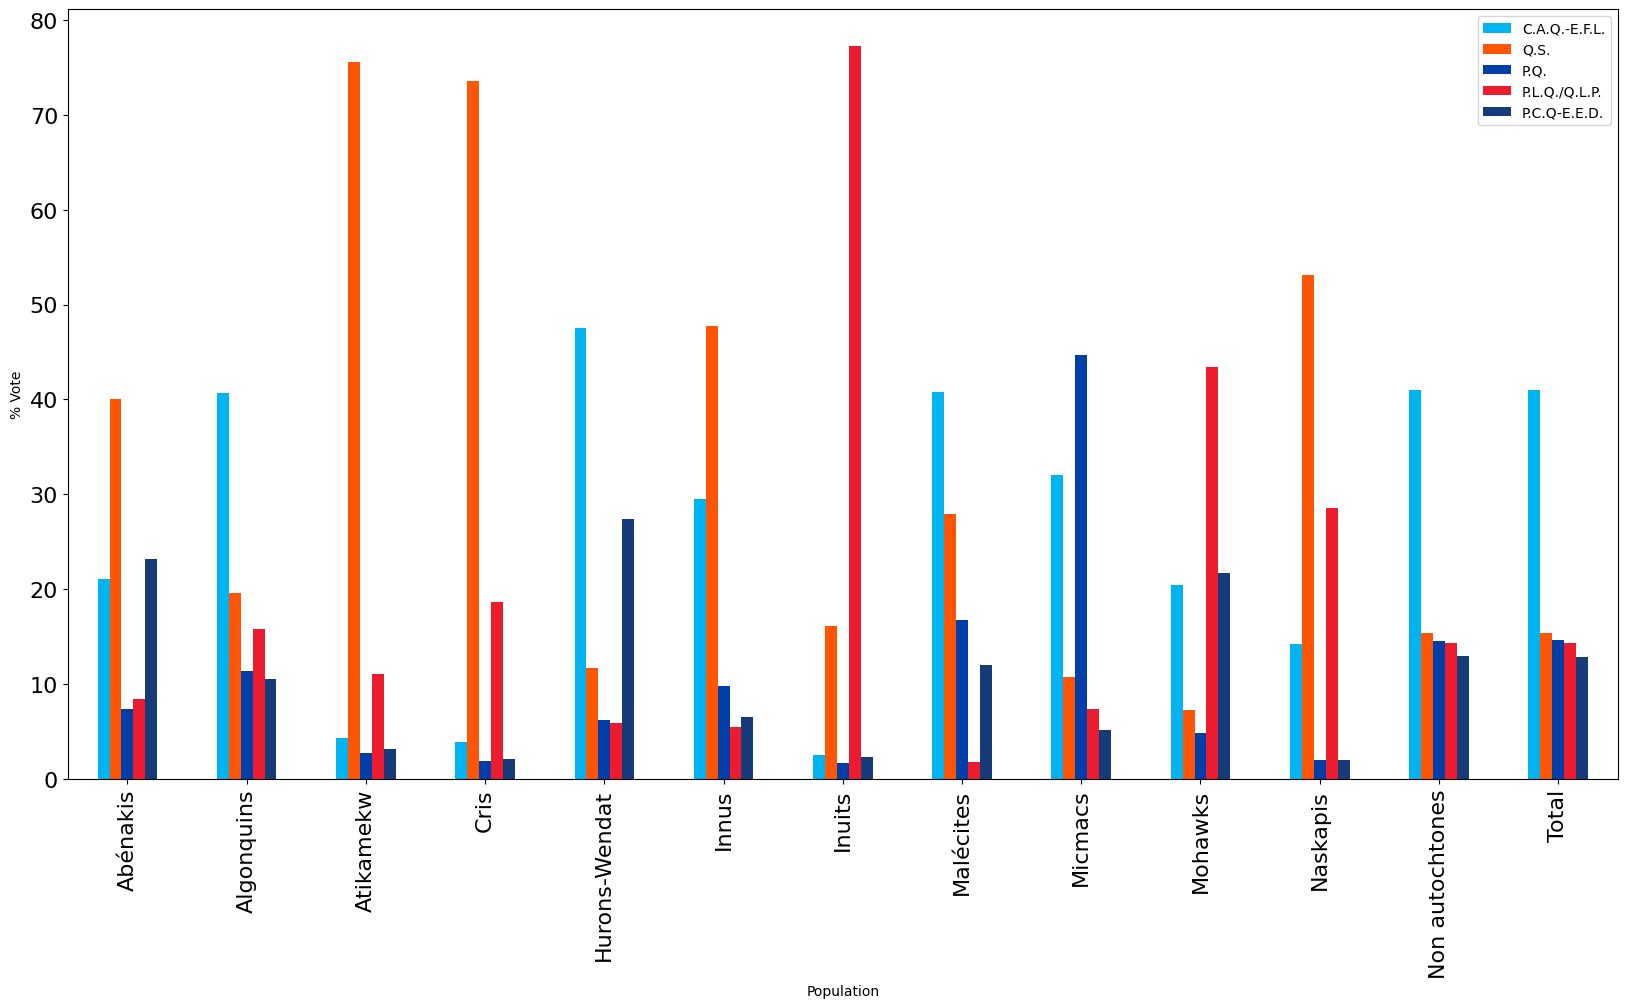

In [12]:
results_by_nation = df_by_nation[[NATION_COL] + list(POLITICAL_COLORS.keys())].set_index(NATION_COL).sort_values([NATION_COL])
plt = results_by_nation.plot.bar(color=POLITICAL_COLORS, figsize=(20, 10), xlabel='Population', ylabel='% Vote', fontsize=16)

# Enregistrer figure dans fichier PNG
plt.get_figure().savefig('assets/resultats_par_population.png', bbox_inches='tight')

### Vote par communauté au sein de chaque nation

Dresse un tableau par nation, indiquant le vote par communauté au sein de cette nation, afin de déceler les différences de comportements électoraux entre communautés.

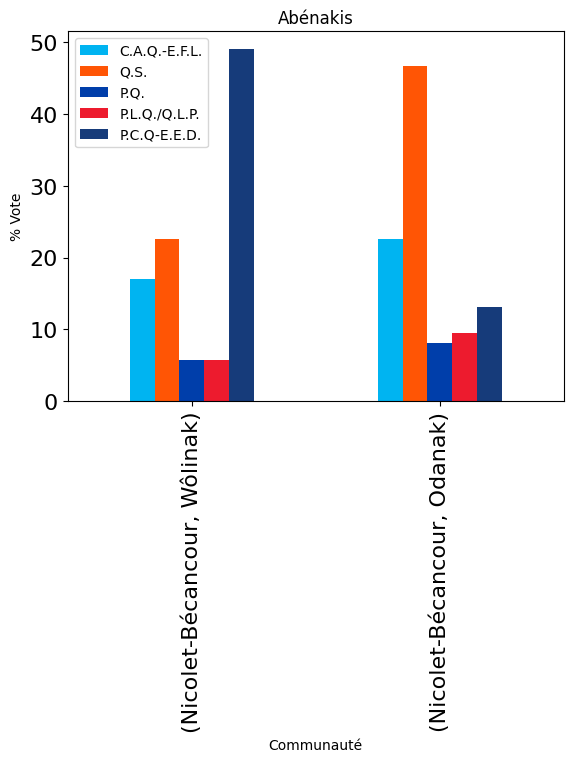

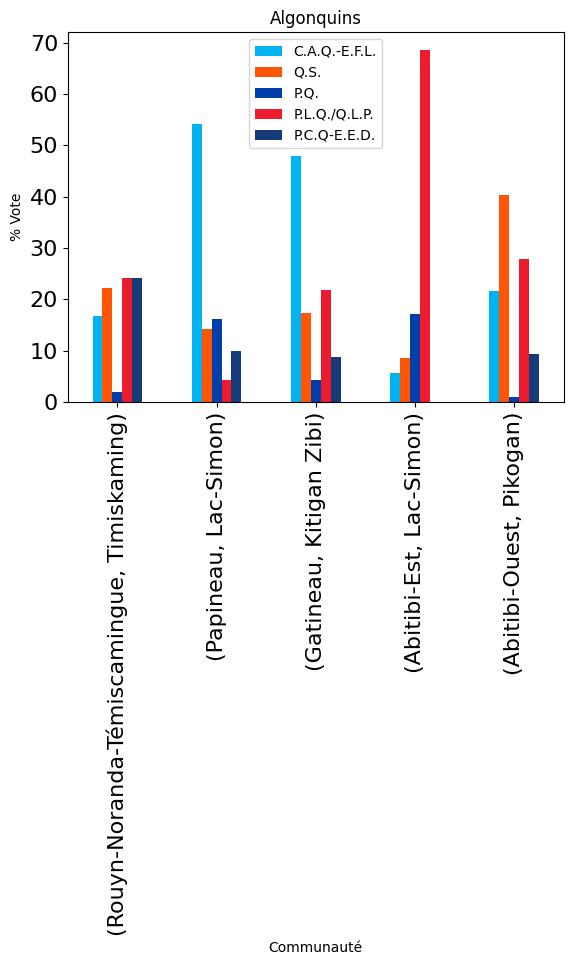

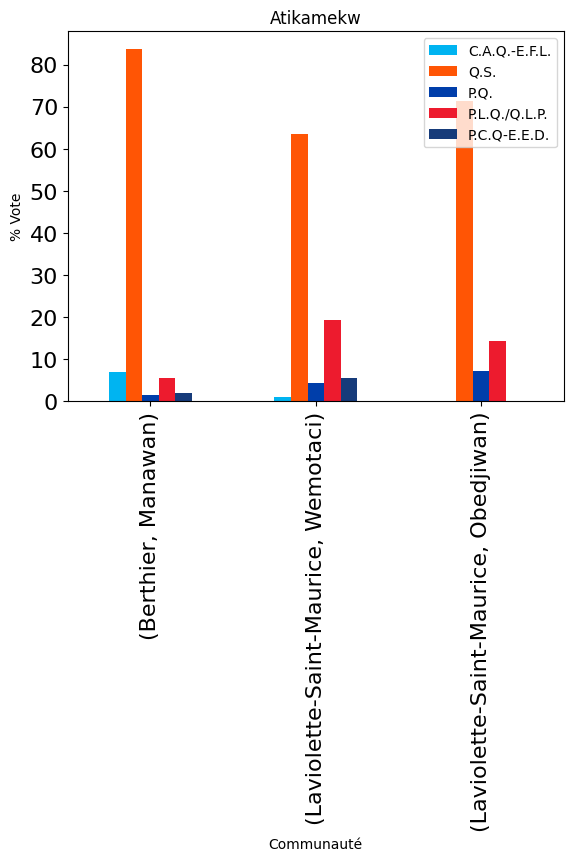

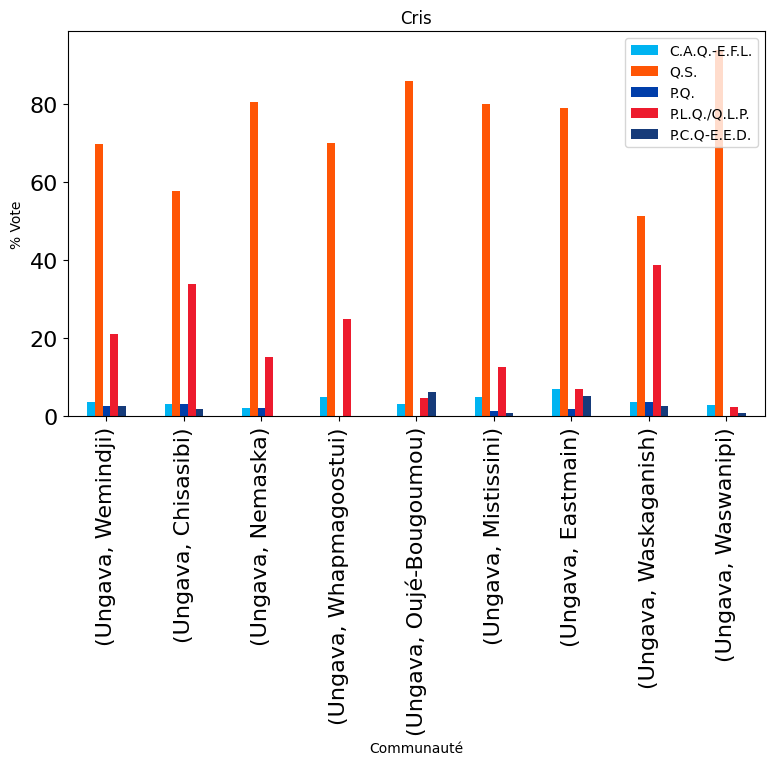

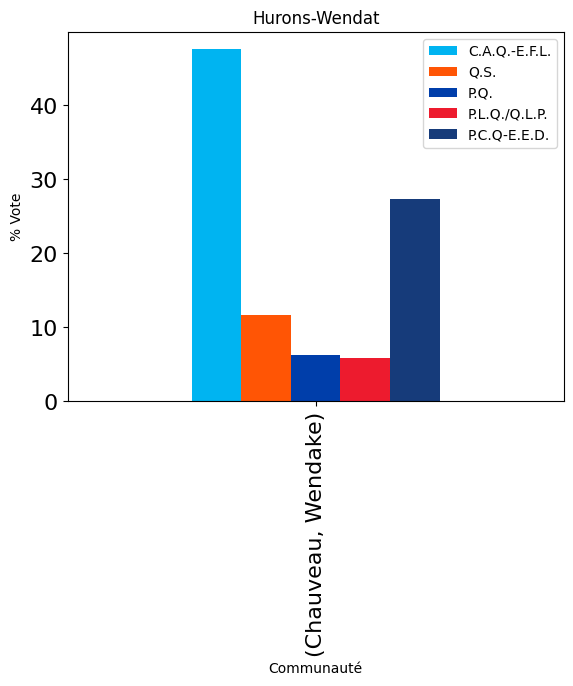

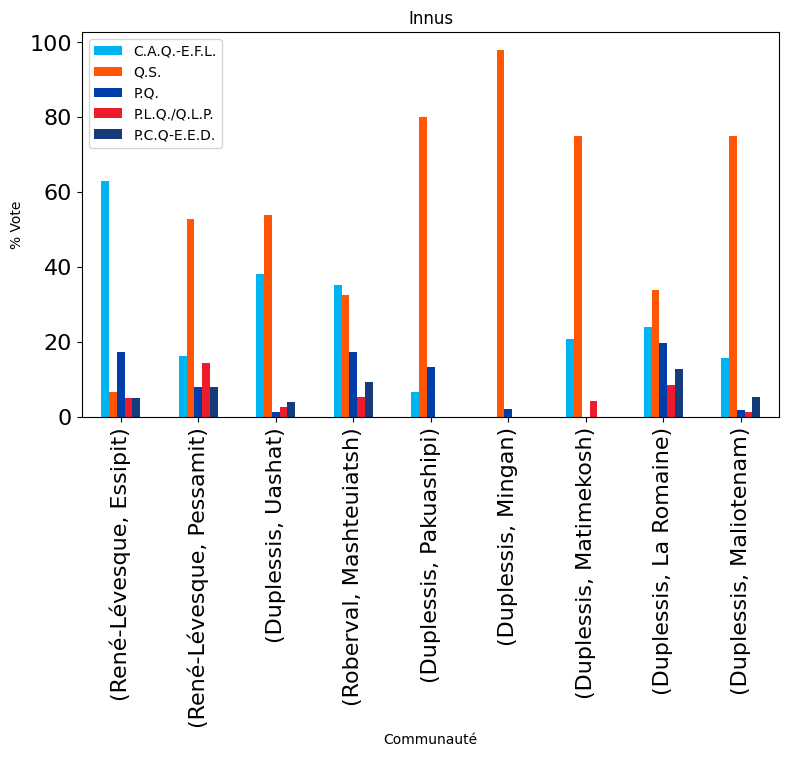

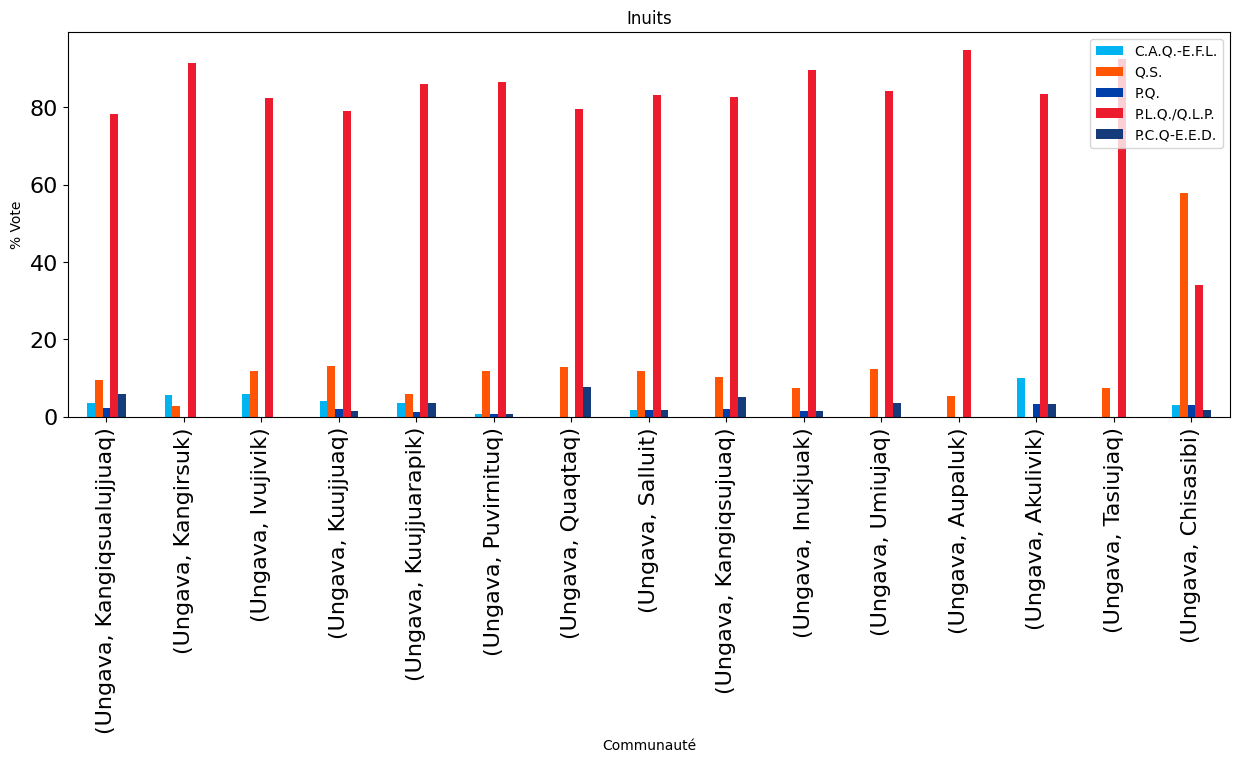

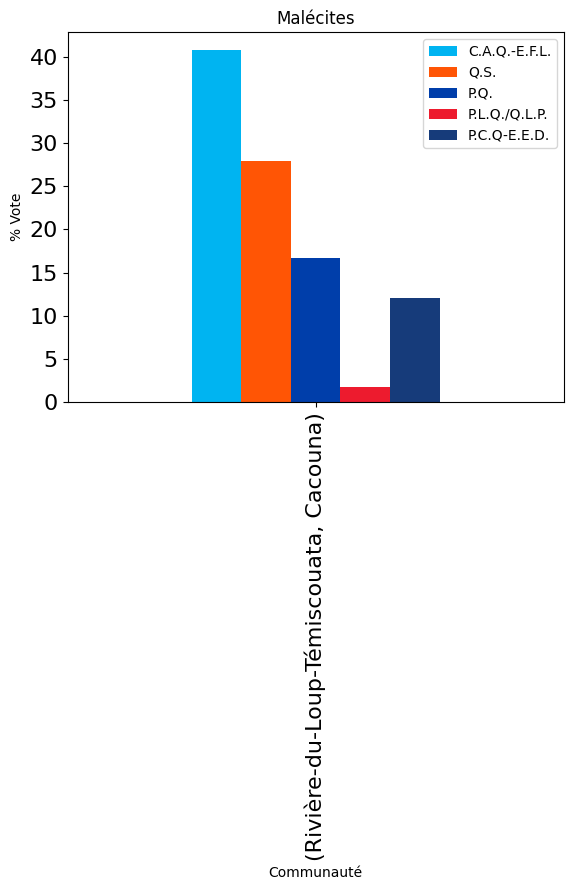

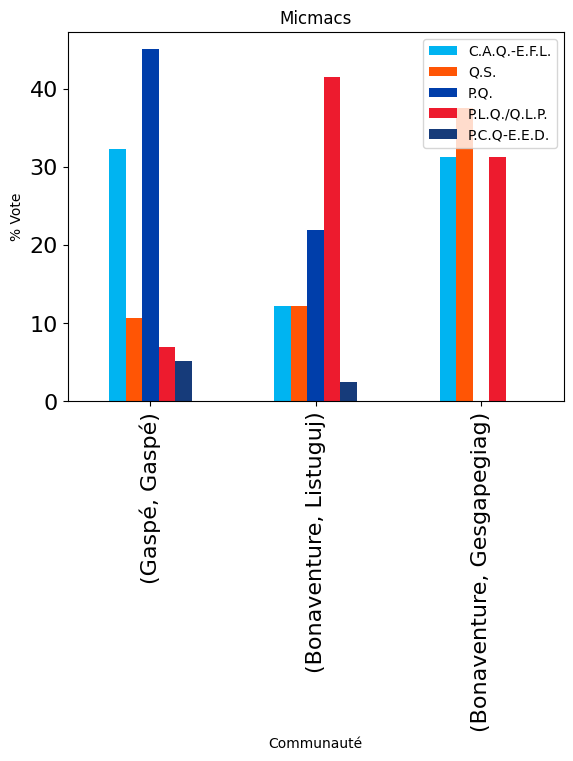

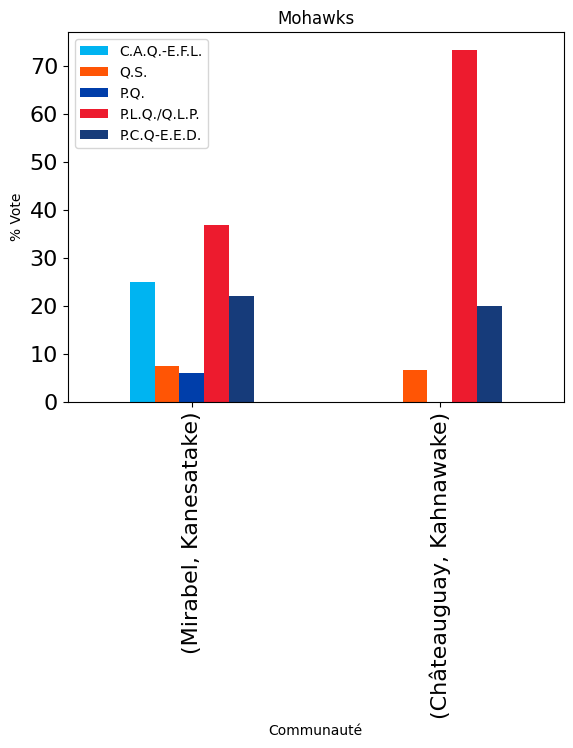

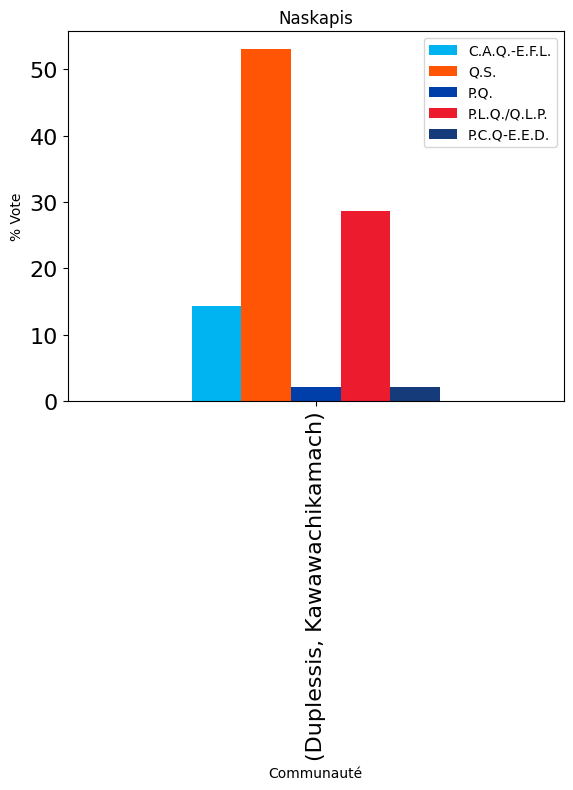

In [13]:
df_by_community = df_indigenous.sort_values(NATION_COL).set_index([NATION_COL, CIRCONSCRIPTION_COL, MUNICIPALITE_COL])
df_by_community = compute_percentages(df_by_community).loc[:,list(POLITICAL_COLORS.keys())].dropna()

os.makedirs(os.path.join('assets', 'nations'), exist_ok=True)
for nation in df_by_community.index.get_level_values(0).unique():
    d = df_by_community.loc[(nation, slice(None), slice(None))]
    kwargs = {}
    if d.shape[0] > 5:
        kwargs['figsize'] = (d.shape[0], 5)
    plt = d.plot.bar(color=POLITICAL_COLORS, xlabel='Communauté', ylabel='% Vote', fontsize=16, title=nation, **kwargs)
    plt.get_figure().savefig(os.path.join('assets', 'nations', f'resultats_{nation.lower()}.png'), bbox_inches='tight')

### Vote par circonscription

Il s'agit ici de voir, pour chaque circonscription, le vote des nations (les non-autochtones formant une nation fictive), afin de comparer les comportements électoraux entre populations voisines.

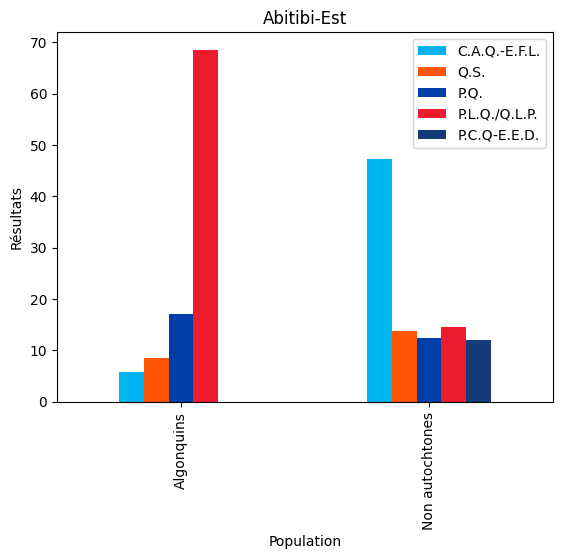

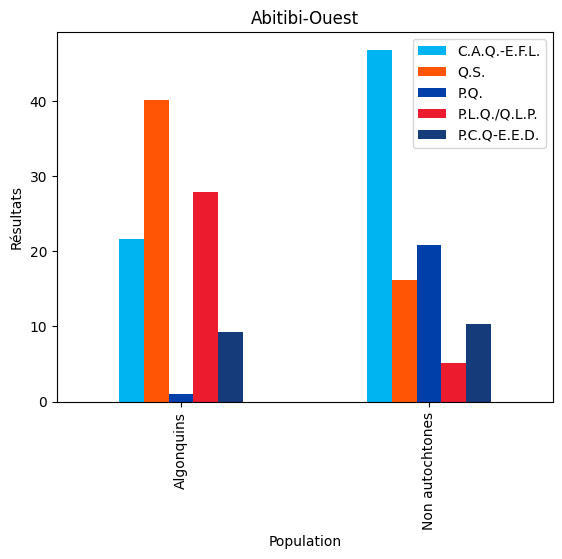

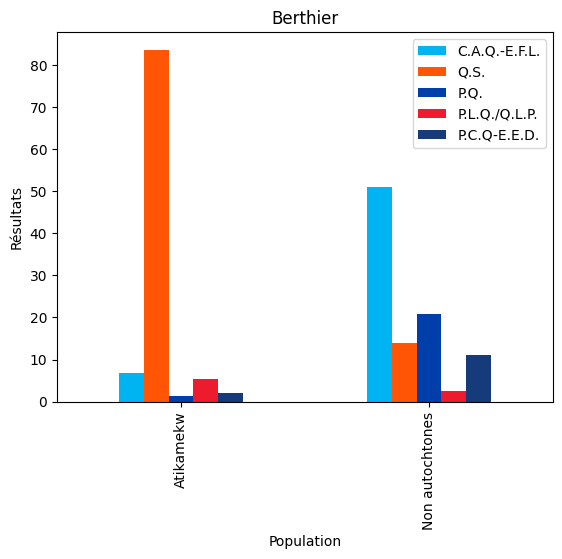

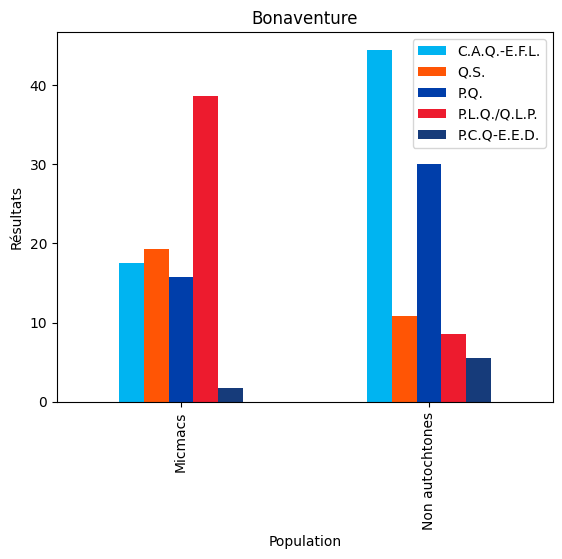

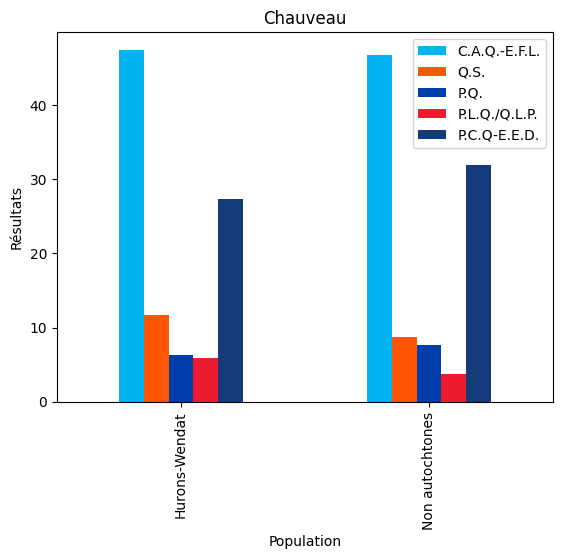

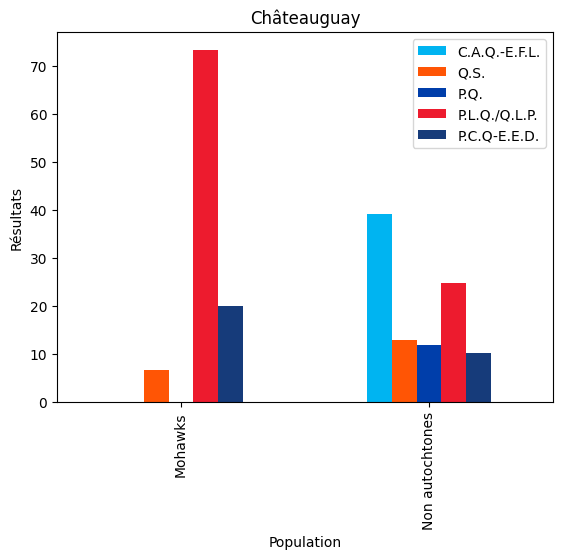

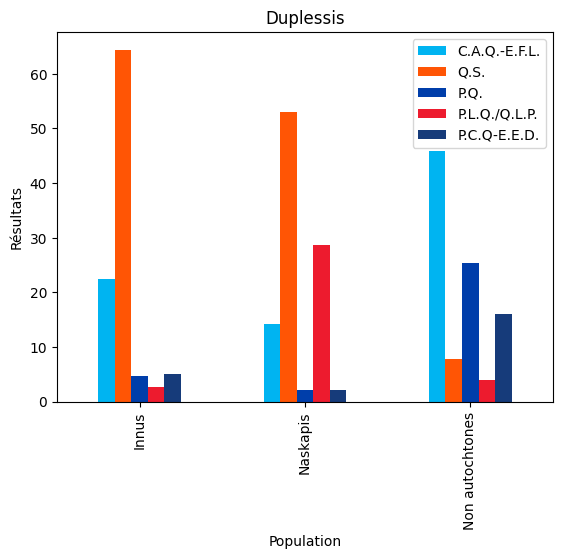

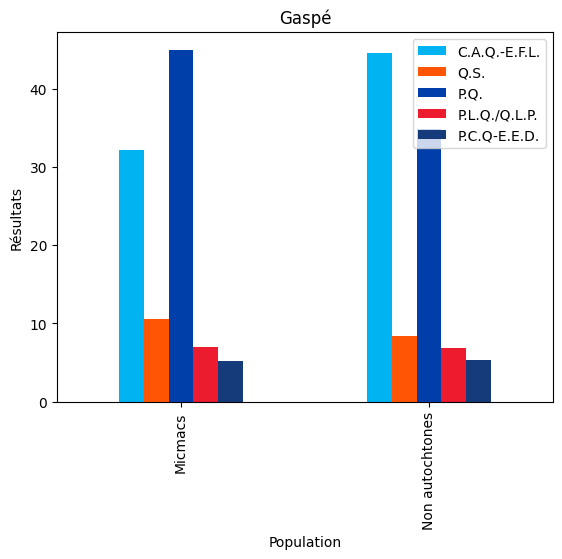

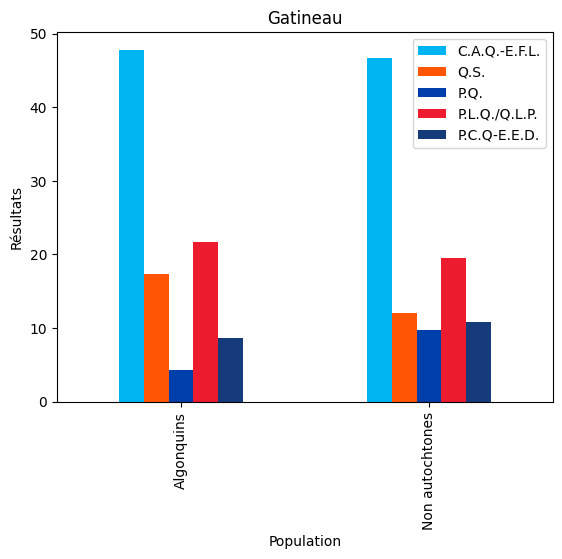

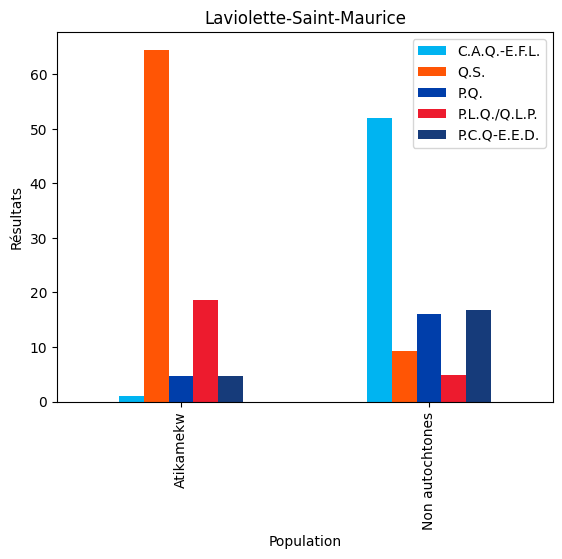

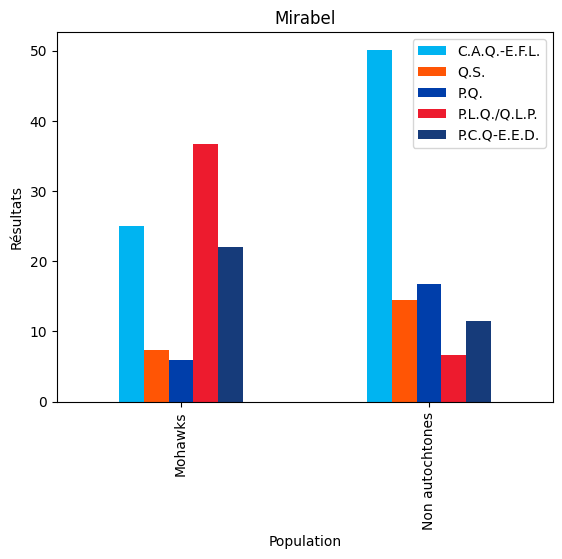

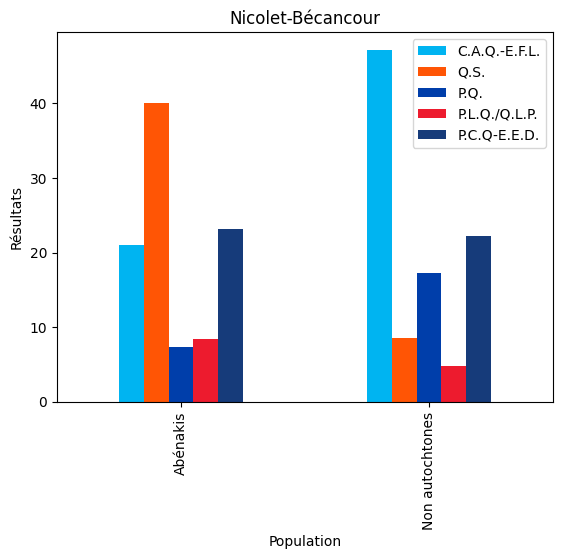

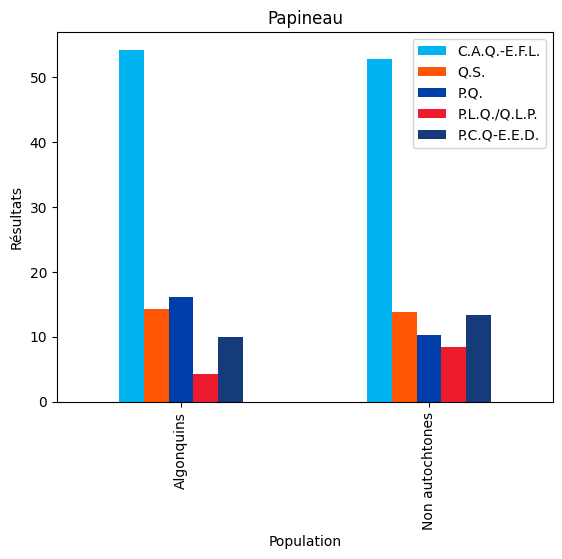

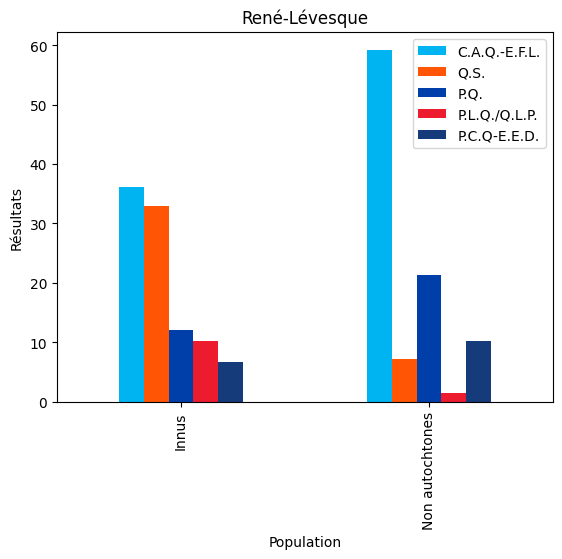

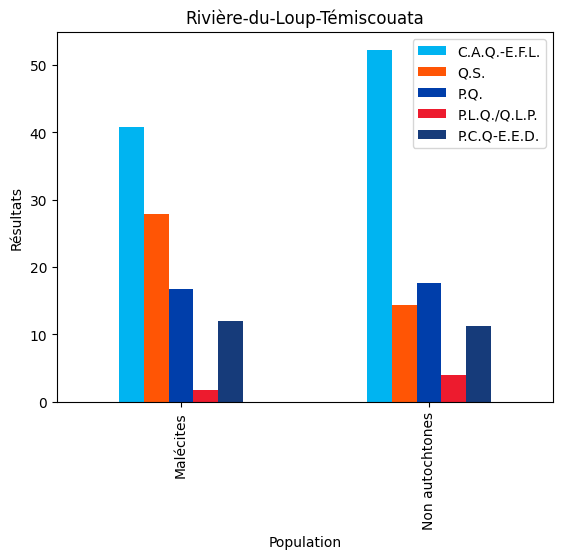

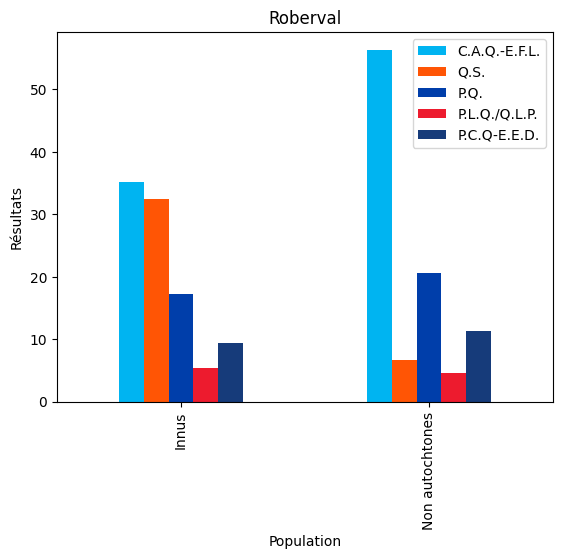

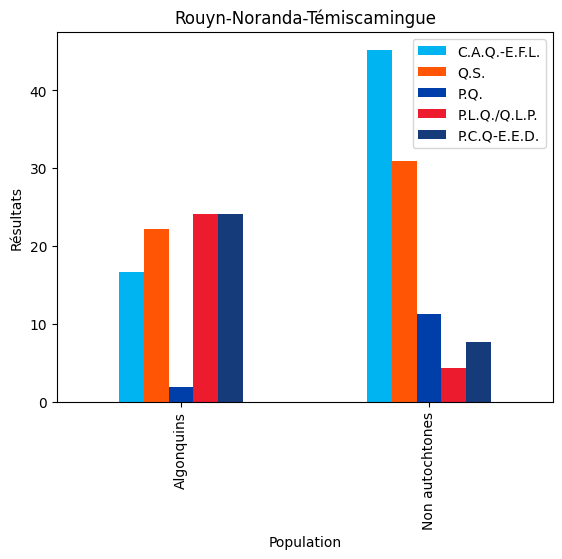

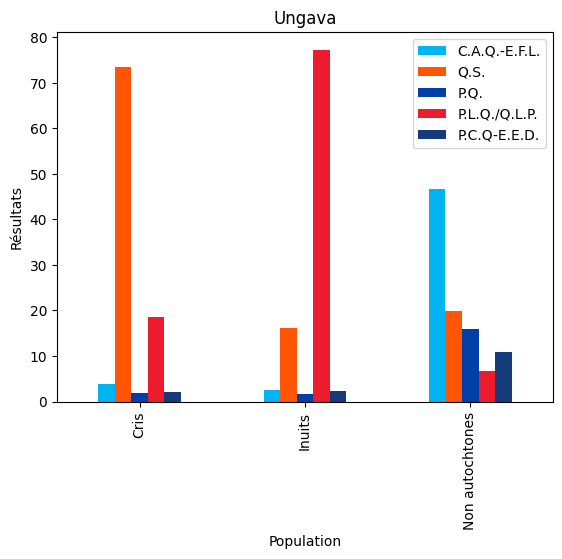

In [14]:
os.makedirs(os.path.join('assets', 'circonscriptions'), exist_ok=True)
for district in indigenous_districts:
    d = df_by_nation_by_discrict[df_by_nation_by_discrict[CIRCONSCRIPTION_COL] == district]
    d = d[d[NATION_COL] != 'Total']
    d = d[[NATION_COL] + list(POLITICAL_COLORS.keys())].set_index(NATION_COL).sort_values([NATION_COL])
    plt = d.plot.bar(color=POLITICAL_COLORS, title=district, xlabel='Population', ylabel='Résultats')
    plt.get_figure().savefig(os.path.join('assets', 'circonscriptions', f'resultats_{district.lower()}.png'), bbox_inches='tight')

### Petits partis

In [15]:
minor_parties = list(set(parties.keys()) - set(POLITICAL_COLORS.keys()))

minor_results_by_nation = df_by_nation[[NATION_COL] + minor_parties].set_index(NATION_COL).sort_values([NATION_COL])
minor_results_by_nation = minor_results_by_nation.query(' or '.join([f'`{party}` > 0' for party in minor_parties]))
minor_results_by_nation['Meilleur petit parti'] = minor_results_by_nation.idxmax(axis=1, numeric_only=True)
minor_results_by_nation['Score'] = minor_results_by_nation.max(axis=1, numeric_only=True)
minor_results_by_nation.reset_index(inplace=True)
minor_results_by_nation[[NATION_COL, 'Meilleur petit parti', 'Score']].style


,Nation,Meilleur petit parti,Score
0,Algonquins,P.V.Q./G.P.Q.,1.926782
1,Atikamekw,A.F.C.,1.574803
2,Hurons-Wendat,P.N.,0.480000
3,Innus,C.Q.,0.899101
4,Malécites,C.Q.,0.734214
5,Micmacs,U.F.F.,0.062709
6,Mohawks,D.D.,1.204819
7,Non autochtones,P.V.Q./G.P.Q.,0.756697
8,Total,P.V.Q./G.P.Q.,0.755054


## 